In [23]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re

In [24]:
def extract_v_gene_info(gene_name):
    """
    Extract V gene information at different levels of granularity.
    
    Args:
        gene_name (str): Full V gene name
        
    Returns:
        dict: Dictionary with full, simplified, and family V gene names
    """
    if pd.isna(gene_name) or gene_name == '':
        return {'full': None, 'simplified': None, 'family': None}
    
    gene_name = str(gene_name).strip()
    
    # Full V gene name
    full_v_gene = gene_name
    
    # Simplified V gene (remove allelic variants like *01, *02, etc.)
    simplified_v_gene = re.sub(r'\*\d+', '', gene_name)
    
    # V gene family (extract just the family part, e.g., IGHV1, IGLV2, etc.)
    family_match = re.match(r'(IG[HLK]V\d+)', gene_name)
    v_gene_family = family_match.group(1) if family_match else gene_name.split('-')[0]
    
    return {
        'full': full_v_gene,
        'simplified': simplified_v_gene,
        'family': v_gene_family
    }

def analyze_v_gene_consistency_by_groups(csv_file_path, min_sequences=4):
    """
    Analyze V gene consistency for generated light chains grouped by heavy chain,
    comparing all four prediction combinations:
    - Naive (0,0): Both heavy and light predicted as naive
    - Memory (1,1): Both heavy and light predicted as memory  
    - Mismatching naive (0,1): Heavy naive, light memory
    - Mismatching memory (1,0): Heavy memory, light naive
    
    Args:
        csv_file_path (str): Path to the CSV file
        min_sequences (int): Minimum number of sequences required per heavy chain (default: 2)
        
    Returns:
        dict: Analysis results for each group and V gene level
    """
    
    # Read the CSV file
    print("Reading CSV file...")
    df = pd.read_csv(csv_file_path)
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    print(f"Total rows: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"Minimum sequences required per heavy chain: {min_sequences}")
    
    # Create all four groups based on predictions
    naive_group = df[(df['predicted_input_heavy_seq_label'] == 0) & 
                     (df['predicted_gen_light_seq_label'] == 0)]
    memory_group = df[(df['predicted_input_heavy_seq_label'] == 1) & 
                      (df['predicted_gen_light_seq_label'] == 1)]
    mismatch_naive_group = df[(df['predicted_input_heavy_seq_label'] == 0) & 
                              (df['predicted_gen_light_seq_label'] == 1)]
    mismatch_memory_group = df[(df['predicted_input_heavy_seq_label'] == 1) & 
                               (df['predicted_gen_light_seq_label'] == 0)]
    
    print(f"\nGroup sizes (before filtering):")
    print(f"Naive (0,0): {len(naive_group)} rows")
    print(f"Memory (1,1): {len(memory_group)} rows")
    print(f"Mismatching naive (0,1): {len(mismatch_naive_group)} rows")
    print(f"Mismatching memory (1,0): {len(mismatch_memory_group)} rows")
    
    # Filter groups to only include heavy chains with >= min_sequences
    def filter_by_min_sequences(group_df, group_name):
        if len(group_df) == 0:
            return group_df
        
        # Count sequences per heavy chain
        heavy_chain_counts = group_df.groupby('heavy_chain_number').size()
        valid_heavy_chains = heavy_chain_counts[heavy_chain_counts >= min_sequences].index
        
        # Filter to only valid heavy chains
        filtered_df = group_df[group_df['heavy_chain_number'].isin(valid_heavy_chains)]
        
        print(f"\n{group_name} group filtering:")
        print(f"  Before: {len(group_df)} rows, {len(heavy_chain_counts)} heavy chains")
        print(f"  Heavy chains with < {min_sequences} sequences: {(heavy_chain_counts < min_sequences).sum()}")
        print(f"  After: {len(filtered_df)} rows, {len(valid_heavy_chains)} heavy chains")
        
        return filtered_df
    
    naive_group = filter_by_min_sequences(naive_group, "Naive (0,0)")
    memory_group = filter_by_min_sequences(memory_group, "Memory (1,1)")
    mismatch_naive_group = filter_by_min_sequences(mismatch_naive_group, "Mismatch Naive (0,1)")
    mismatch_memory_group = filter_by_min_sequences(mismatch_memory_group, "Mismatch Memory (1,0)")
    
    # Analyze each group separately
    results = {
        'naive': {'full': {}, 'simplified': {}, 'family': {}},
        'memory': {'full': {}, 'simplified': {}, 'family': {}},
        'mismatch_naive': {'full': {}, 'simplified': {}, 'family': {}},
        'mismatch_memory': {'full': {}, 'simplified': {}, 'family': {}},
        'comparison': {}
    }
    
    group_data = [
        ('naive', naive_group),
        ('memory', memory_group), 
        ('mismatch_naive', mismatch_naive_group),
        ('mismatch_memory', mismatch_memory_group)
    ]
    
    for group_name, group_df in group_data:
        print(f"\nAnalyzing {group_name} group...")
        
        # Group by heavy chain number
        heavy_chain_groups = group_df.groupby('heavy_chain_number')
        unique_heavy_chains = len(heavy_chain_groups)
        
        print(f"Number of unique heavy chains in {group_name} group: {unique_heavy_chains}")
        
        # Initialize results storage for this group
        group_results = {
            'full': {'consistent': [], 'inconsistent': [], 'frequency_analysis': [], 'stats': {}},
            'simplified': {'consistent': [], 'inconsistent': [], 'frequency_analysis': [], 'stats': {}},
            'family': {'consistent': [], 'inconsistent': [], 'frequency_analysis': [], 'stats': {}}
        }
        
        # Analyze each heavy chain group
        for heavy_chain_num, group in heavy_chain_groups:
            # Extract V gene information for all generated light chains in this group
            v_gene_info = []
            
            for _, row in group.iterrows():
                v_info = extract_v_gene_info(row['gen_light_gene_name'])
                v_gene_info.append(v_info)
            
            # Check consistency at each level
            for level in ['full', 'simplified', 'family']:
                v_genes_at_level = [info[level] for info in v_gene_info if info[level] is not None]
                
                if len(v_genes_at_level) == 0:
                    continue
                    
                # Calculate V gene frequencies
                v_gene_counts = {v: v_genes_at_level.count(v) for v in set(v_genes_at_level)}
                total_generated = len(v_genes_at_level)
                v_gene_frequencies = {v: (count / total_generated) * 100 for v, count in v_gene_counts.items()}
                
                # Check if all V genes are the same
                unique_v_genes = set(v_genes_at_level)
                
                heavy_chain_info = {
                    'heavy_chain_number': heavy_chain_num,
                    'heavy_chain_gene': group['heavy_chain_gene_name'].iloc[0],
                    'true_light_gene': group['true_light_gene_name'].iloc[0],
                    'generated_count': total_generated,
                    'unique_v_genes': list(unique_v_genes),
                    'v_gene_counts': v_gene_counts,
                    'v_gene_frequencies': v_gene_frequencies,
                    'group': group_name
                }
                
                # Add frequency analysis data
                freq_analysis_info = heavy_chain_info.copy()
                
                # Add dominant V gene information
                dominant_v_gene = max(v_gene_frequencies, key=v_gene_frequencies.get)
                dominant_frequency = v_gene_frequencies[dominant_v_gene]
                
                freq_analysis_info.update({
                    'dominant_v_gene': dominant_v_gene,
                    'dominant_frequency': dominant_frequency,
                    'dominant_count': v_gene_counts[dominant_v_gene],
                    'unique_v_gene_count': len(unique_v_genes)
                })
                
                # Add individual V gene frequency columns for easier analysis
                for v_gene, freq in v_gene_frequencies.items():
                    freq_analysis_info[f'freq_{v_gene}'] = freq
                    freq_analysis_info[f'count_{v_gene}'] = v_gene_counts[v_gene]
                
                group_results[level]['frequency_analysis'].append(freq_analysis_info)
                
                if len(unique_v_genes) == 1:
                    # All generated light chains use the same V gene
                    heavy_chain_info['consistent_v_gene'] = list(unique_v_genes)[0]
                    group_results[level]['consistent'].append(heavy_chain_info)
                else:
                    # Mixed V gene usage
                    group_results[level]['inconsistent'].append(heavy_chain_info)
        
        # Calculate statistics for this group
        for level in ['full', 'simplified', 'family']:
            total_heavy_chains = len(group_results[level]['consistent']) + len(group_results[level]['inconsistent'])
            consistent_count = len(group_results[level]['consistent'])
            
            # Calculate frequency distribution statistics
            freq_data = group_results[level]['frequency_analysis']
            dominant_freqs = [item['dominant_frequency'] for item in freq_data]
            unique_v_gene_counts = [item['unique_v_gene_count'] for item in freq_data]
            
            group_results[level]['stats'] = {
                'total_heavy_chains': total_heavy_chains,
                'consistent_count': consistent_count,
                'inconsistent_count': len(group_results[level]['inconsistent']),
                'consistency_percentage': (consistent_count / total_heavy_chains * 100) if total_heavy_chains > 0 else 0,
                'avg_dominant_frequency': np.mean(dominant_freqs) if dominant_freqs else 0,
                'median_dominant_frequency': np.median(dominant_freqs) if dominant_freqs else 0,
                'std_dominant_frequency': np.std(dominant_freqs) if dominant_freqs else 0,
                'avg_unique_v_genes': np.mean(unique_v_gene_counts) if unique_v_gene_counts else 0,
                'median_unique_v_genes': np.median(unique_v_gene_counts) if unique_v_gene_counts else 0
            }
        
        results[group_name] = group_results
    
    # Calculate comparison statistics across all groups
    results['comparison'] = calculate_four_group_comparisons(results)
    
    return results

def calculate_four_group_comparisons(results):
    """Calculate statistical comparisons across all four groups."""
    
    comparisons = {}
    group_names = ['naive', 'memory', 'mismatch_naive', 'mismatch_memory']
    
    for level in ['full', 'simplified', 'family']:
        level_comparisons = {}
        
        for group_name in group_names:
            group_stats = results[group_name][level]['stats']
            freq_data = results[group_name][level]['frequency_analysis']
            
            dominant_freqs = [item['dominant_frequency'] for item in freq_data]
            unique_counts = [item['unique_v_gene_count'] for item in freq_data]
            
            level_comparisons[group_name] = {
                'stats': group_stats,
                'dominant_frequencies': dominant_freqs,
                'unique_counts': unique_counts
            }
        
        # Calculate pairwise differences (using naive as baseline)
        baseline = level_comparisons['naive']['stats']
        
        for group_name in group_names:
            if group_name != 'naive':
                current = level_comparisons[group_name]['stats']
                level_comparisons[f'{group_name}_vs_naive'] = {
                    'consistency_diff': current['consistency_percentage'] - baseline['consistency_percentage'],
                    'avg_frequency_diff': current['avg_dominant_frequency'] - baseline['avg_dominant_frequency'],
                    'avg_diversity_diff': current['avg_unique_v_genes'] - baseline['avg_unique_v_genes']
                }
        
        comparisons[level] = level_comparisons
    
    return comparisons

def print_group_comparison_summary(results):
    """Print a comprehensive comparison across all four groups."""
    
    print("\n" + "="*100)
    print("FOUR-GROUP V GENE CONSISTENCY COMPARISON")
    print("="*100)
    
    group_labels = {
        'naive': 'Naive (0,0)',
        'memory': 'Memory (1,1)', 
        'mismatch_naive': 'Mismatch Naive (0,1)',
        'mismatch_memory': 'Mismatch Memory (1,0)'
    }
    
    for level in ['full', 'simplified', 'family']:
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 70)
        
        # Group sizes
        print(f"Group sizes:")
        for group_name, label in group_labels.items():
            stats = results['comparison'][level][group_name]['stats']
            print(f"  {label:20s}: {stats['total_heavy_chains']:4d} heavy chains")
        
        # Consistency comparison
        print(f"\nV Gene Consistency (100% same V gene):")
        for group_name, label in group_labels.items():
            stats = results['comparison'][level][group_name]['stats']
            print(f"  {label:20s}: {stats['consistent_count']:3d} / {stats['total_heavy_chains']:3d} = {stats['consistency_percentage']:5.1f}%")
        
        # Show differences from naive baseline
        print(f"\nDifferences from Naive baseline:")
        for group_name in ['memory', 'mismatch_naive', 'mismatch_memory']:
            if f'{group_name}_vs_naive' in results['comparison'][level]:
                diff = results['comparison'][level][f'{group_name}_vs_naive']
                label = group_labels[group_name]
                print(f"  {label:20s}: {diff['consistency_diff']:+5.1f}% consistency, "
                      f"{diff['avg_frequency_diff']:+5.1f}% avg frequency, "
                      f"{diff['avg_diversity_diff']:+4.2f} diversity")
        
        # Dominant frequency comparison
        print(f"\nDominant V Gene Frequency (average ± std):")
        for group_name, label in group_labels.items():
            stats = results['comparison'][level][group_name]['stats']
            print(f"  {label:20s}: {stats['avg_dominant_frequency']:5.1f}% ± {stats['std_dominant_frequency']:4.1f}%")
        
        # V gene diversity comparison
        print(f"\nV Gene Diversity (avg unique V genes per heavy chain):")
        for group_name, label in group_labels.items():
            stats = results['comparison'][level][group_name]['stats']
            print(f"  {label:20s}: {stats['avg_unique_v_genes']:4.2f}")

def analyze_frequency_thresholds_by_four_groups(results):
    """Analyze frequency thresholds across all four groups."""
    
    print(f"\n" + "="*100)
    print("FREQUENCY THRESHOLD ANALYSIS BY ALL GROUPS")
    print("="*100)
    
    thresholds = [70, 80, 90, 100]
    group_names = ['naive', 'memory', 'mismatch_naive', 'mismatch_memory']
    group_labels = {
        'naive': 'Naive (0,0)',
        'memory': 'Memory (1,1)', 
        'mismatch_naive': 'Mismatch Naive (0,1)',
        'mismatch_memory': 'Mismatch Memory (1,0)'
    }
    
    for level in ['full', 'simplified', 'family']:
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 70)
        
        for threshold in thresholds:
            print(f"\nFrequency >= {threshold}%:")
            
            for group_name in group_names:
                count = 0
                for item in results[group_name][level]['frequency_analysis']:
                    if item['dominant_frequency'] >= threshold:
                        count += 1
                
                total = len(results[group_name][level]['frequency_analysis'])
                pct = (count / total * 100) if total > 0 else 0
                label = group_labels[group_name]
                
                print(f"  {label:20s}: {count:3d}/{total:3d} = {pct:5.1f}%")

def interpret_group_patterns(results):
    """Provide biological interpretation of the four-group patterns."""
    
    print(f"\n" + "="*100)
    print("BIOLOGICAL INTERPRETATION OF GROUP PATTERNS")
    print("="*100)
    
    print(f"""
    The four groups represent different combinations of heavy and light chain predictions:
    
    1. NAIVE (0,0): Both heavy and light chains predicted as naive
       - Expected: Higher diversity, lower consistency (exploring repertoire)
    
    2. MEMORY (1,1): Both heavy and light chains predicted as memory  
       - Expected: Lower diversity, higher consistency (focused response)
    
    3. MISMATCH NAIVE (0,1): Heavy naive, light memory
       - Interpretation: Naive heavy chain paired with memory-like light chain
       - Possible: Early activation or cross-reactivity patterns
    
    4. MISMATCH MEMORY (1,0): Heavy memory, light naive
       - Interpretation: Memory heavy chain paired with naive-like light chain  
       - Possible: Receptor editing or unusual pairing patterns
    """)
    
    # Analyze patterns at simplified V gene level (most biologically relevant)
    level = 'simplified'
    
    # Get consistency percentages for interpretation
    naive_consistency = results['comparison'][level]['naive']['stats']['consistency_percentage']
    memory_consistency = results['comparison'][level]['memory']['stats']['consistency_percentage']
    mismatch_naive_consistency = results['comparison'][level]['mismatch_naive']['stats']['consistency_percentage']
    mismatch_memory_consistency = results['comparison'][level]['mismatch_memory']['stats']['consistency_percentage']
    
    print(f"\nKEY FINDINGS (at {level} V gene level):")
    print(f"-" * 50)
    
    # Compare memory vs naive
    if memory_consistency > naive_consistency + 5:
        print(f"✓ Memory B cells show HIGHER consistency than naive ({memory_consistency:.1f}% vs {naive_consistency:.1f}%)")
        print(f"  → Supports biological expectation of focused memory responses")
    elif naive_consistency > memory_consistency + 5:
        print(f"⚠ Naive B cells show HIGHER consistency than memory ({naive_consistency:.1f}% vs {memory_consistency:.1f}%)")
        print(f"  → Unexpected pattern - may indicate model artifact")
    else:
        print(f"- Similar consistency between naive and memory groups")
    
    # Analyze mismatch groups
    mismatch_groups = [
        ('mismatch_naive', mismatch_naive_consistency, 'Mismatch Naive (0,1)'),
        ('mismatch_memory', mismatch_memory_consistency, 'Mismatch Memory (1,0)')
    ]
    
    for group_name, consistency, label in mismatch_groups:
        if consistency > max(naive_consistency, memory_consistency) + 5:
            print(f"⚠ {label} shows unexpectedly HIGH consistency ({consistency:.1f}%)")
        elif consistency < min(naive_consistency, memory_consistency) - 5:
            print(f"⚠ {label} shows unexpectedly LOW consistency ({consistency:.1f}%)")
        else:
            print(f"- {label} shows intermediate consistency ({consistency:.1f}%)")


def analyze_frequency_thresholds_by_group(results):
    """Analyze frequency thresholds separately for each group."""
    
    print(f"\n" + "="*90)
    print("FREQUENCY THRESHOLD ANALYSIS BY GROUP")
    print("="*90)
    
    thresholds = [70, 80, 90, 100]
    
    for level in ['full', 'simplified', 'family']:
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 50)
        
        for threshold in thresholds:
            naive_count = 0
            memory_count = 0
            
            # Count naive cases above threshold
            for item in results['naive'][level]['frequency_analysis']:
                if item['dominant_frequency'] >= threshold:
                    naive_count += 1
            
            # Count memory cases above threshold
            for item in results['memory'][level]['frequency_analysis']:
                if item['dominant_frequency'] >= threshold:
                    memory_count += 1
            
            naive_total = len(results['naive'][level]['frequency_analysis'])
            memory_total = len(results['memory'][level]['frequency_analysis'])
            
            naive_pct = (naive_count / naive_total * 100) if naive_total > 0 else 0
            memory_pct = (memory_count / memory_total * 100) if memory_total > 0 else 0
            
            print(f"Frequency >= {threshold}%:")
            print(f"  Naive:  {naive_count}/{naive_total} = {naive_pct:.1f}%")
            print(f"  Memory: {memory_count}/{memory_total} = {memory_pct:.1f}%")
            print(f"  Difference: {memory_pct - naive_pct:+.1f} percentage points")

def save_group_results(results, output_prefix='v_gene_group_analysis'):
    """Save results separated by group."""
    
    for group in ['naive', 'memory']:
        for level in ['full', 'simplified', 'family']:
            # Save frequency analysis
            if results[group][level]['frequency_analysis']:
                freq_df = pd.DataFrame(results[group][level]['frequency_analysis'])
                filename = f'{output_prefix}_{group}_{level}_frequency_analysis.csv'
                freq_df.to_csv(filename, index=False)
                print(f"Saved {group} {level} frequency analysis to: {filename}")
            
            # Save consistent cases
            if results[group][level]['consistent']:
                consistent_df = pd.DataFrame(results[group][level]['consistent'])
                filename = f'{output_prefix}_{group}_{level}_consistent.csv'
                consistent_df.to_csv(filename, index=False)
                print(f"Saved {group} {level} consistent cases to: {filename}")
    
    # Save comparison summary
    comparison_data = []
    for level in ['full', 'simplified', 'family']:
        comp = results['comparison'][level]
        comparison_data.append({
            'level': level,
            'naive_total_heavy_chains': comp['naive_stats']['total_heavy_chains'],
            'memory_total_heavy_chains': comp['memory_stats']['total_heavy_chains'],
            'naive_consistency_pct': comp['naive_stats']['consistency_percentage'],
            'memory_consistency_pct': comp['memory_stats']['consistency_percentage'],
            'consistency_difference': comp['consistency_difference'],
            'naive_avg_dominant_freq': comp['naive_stats']['avg_dominant_frequency'],
            'memory_avg_dominant_freq': comp['memory_stats']['avg_dominant_frequency'],
            'avg_frequency_difference': comp['avg_frequency_difference'],
            'naive_avg_unique_v_genes': comp['naive_stats']['avg_unique_v_genes'],
            'memory_avg_unique_v_genes': comp['memory_stats']['avg_unique_v_genes'],
            'avg_diversity_difference': comp['avg_diversity_difference']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv(f'{output_prefix}_comparison_summary.csv', index=False)
    print(f"Saved comparison summary to: {output_prefix}_comparison_summary.csv")

def analyze_frequency_patterns(results, min_frequency=70):
    """
    Analyze patterns where V genes appear with high frequency.
    
    Args:
        results (dict): Analysis results
        min_frequency (float): Minimum frequency threshold (default 70%)
        
    Returns:
        dict: High-frequency patterns analysis
    """
    
    frequency_patterns = {}
    
    for level in ['full', 'simplified', 'family']:
        patterns = []
        
        for item in results[level]['frequency_analysis']:
            # Check if any V gene appears with frequency >= min_frequency
            high_freq_genes = {v_gene: freq for v_gene, freq in item['v_gene_frequencies'].items() 
                             if freq >= min_frequency}
            
            if high_freq_genes:
                pattern_info = {
                    'heavy_chain_number': item['heavy_chain_number'],
                    'heavy_chain_gene': item['heavy_chain_gene'],
                    'true_light_gene': item['true_light_gene'],
                    'high_frequency_genes': high_freq_genes,
                    'dominant_v_gene': item['dominant_v_gene'],
                    'dominant_frequency': item['dominant_frequency'],
                    'total_generated': item['generated_count']
                }
                patterns.append(pattern_info)
        
        frequency_patterns[level] = {
            'patterns': patterns,
            'count': len(patterns),
            'percentage': (len(patterns) / len(results[level]['frequency_analysis']) * 100) 
                         if results[level]['frequency_analysis'] else 0
        }
    
    return frequency_patterns

def print_frequency_analysis(frequency_patterns, min_frequency=70):
    """Print frequency pattern analysis."""
    
    print(f"\n" + "="*80)
    print(f"HIGH FREQUENCY V GENE PATTERNS (>={min_frequency}%)")
    print("="*80)
    
    for level in ['full', 'simplified', 'family']:
        patterns = frequency_patterns[level]
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 40)
        print(f"Heavy chains with V gene frequency >= {min_frequency}%: {patterns['count']} ({patterns['percentage']:.1f}%)")
        
        if patterns['patterns']:
            print(f"\nTop 10 examples:")
            sorted_patterns = sorted(patterns['patterns'], 
                                   key=lambda x: x['dominant_frequency'], reverse=True)
            
            for i, pattern in enumerate(sorted_patterns[:10]):
                high_freq_str = ", ".join([f"{gene}: {freq:.1f}%" 
                                         for gene, freq in pattern['high_frequency_genes'].items()])
                print(f"  {i+1}. Heavy chain {pattern['heavy_chain_number']}: {high_freq_str}")

def save_detailed_results(results, output_prefix='v_gene_analysis_min_4_seqs'):
    """Save detailed results to CSV files."""
    
    for level in ['full', 'simplified', 'family']:
        # Save frequency analysis (most comprehensive)
        if results[level]['frequency_analysis']:
            freq_df = pd.DataFrame(results[level]['frequency_analysis'])
            freq_df.to_csv(f'{output_prefix}_{level}_frequency_analysis.csv', index=False)
            print(f"Saved frequency analysis for {level} V genes to: {output_prefix}_{level}_frequency_analysis.csv")
        
        # Save consistent cases
        if results[level]['consistent']:
            consistent_df = pd.DataFrame(results[level]['consistent'])
            consistent_df.to_csv(f'{output_prefix}_{level}_consistent.csv', index=False)
            print(f"Saved consistent {level} V gene results to: {output_prefix}_{level}_consistent.csv")
        
        # Save inconsistent cases with detailed V gene breakdown
        if results[level]['inconsistent']:
            inconsistent_data = []
            for item in results[level]['inconsistent']:
                base_info = {
                    'heavy_chain_number': item['heavy_chain_number'],
                    'heavy_chain_gene': item['heavy_chain_gene'],
                    'true_light_gene': item['true_light_gene'],
                    'generated_count': item['generated_count'],
                    'unique_v_gene_count': len(item['unique_v_genes'])
                }
                
                # Add V gene counts and frequencies
                for v_gene, count in item['v_gene_counts'].items():
                    base_info[f'count_{v_gene}'] = count
                    base_info[f'freq_{v_gene}'] = (count / item['generated_count']) * 100
                
                inconsistent_data.append(base_info)
            
            inconsistent_df = pd.DataFrame(inconsistent_data)
            inconsistent_df.to_csv(f'{output_prefix}_{level}_inconsistent.csv', index=False)
            print(f"Saved inconsistent {level} V gene results to: {output_prefix}_{level}_inconsistent.csv")




In [25]:
def main():
    """Main function to run the four-group comparison analysis."""
    
    # Replace with your actual CSV file path
    csv_file_path = '/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions_merged_genes.csv'
    
    try:
        # Run the four-group analysis
        print("Starting four-group V gene analysis...")
        print("Groups: Naive (0,0), Memory (1,1), Mismatch Naive (0,1), Mismatch Memory (1,0)")
        results = analyze_v_gene_consistency_by_groups(csv_file_path)
        
        # Print comprehensive comparison
        print_group_comparison_summary(results)
        
        # Analyze frequency thresholds
        analyze_frequency_thresholds_by_four_groups(results)

        # analyze_frequency_thresholds_by_group(results)
        
        # # Print frequency patterns
        # frequency_patterns = analyze_frequency_patterns(results)
        # print_frequency_analysis(frequency_patterns)
        
        # Provide biological interpretation
        # interpret_group_patterns(results)
        

        
        
        print(f"\n" + "="*100)
        print("ANALYSIS COMPLETE!")
        print("="*100)
        print(f"Generated files:")
        print(f"  - *_naive_*_frequency_analysis.csv: Naive group (0,0) detailed analysis")
        print(f"  - *_memory_*_frequency_analysis.csv: Memory group (1,1) detailed analysis") 
        print(f"  - *_mismatch_naive_*_frequency_analysis.csv: Mismatch naive (0,1) detailed analysis")
        print(f"  - *_mismatch_memory_*_frequency_analysis.csv: Mismatch memory (1,0) detailed analysis")
        print(f"  - *_comprehensive_comparison.csv: Statistical comparison across all groups")
        
        print(f"\nKey research questions to explore:")
        print(f"  1. Do memory B cells (1,1) show higher V gene consistency than naive (0,0)?")
        print(f"  2. Are mismatched groups (0,1) and (1,0) intermediate or outliers?")
        print(f"  3. Which group shows the most focused V gene usage?")
        print(f"  4. Do mismatch patterns suggest biological processes like receptor editing?")
        print(f"  5. How do the four groups rank in terms of V gene diversity?")
        
        return results
        
    except FileNotFoundError:
        print(f"Error: Could not find the file '{csv_file_path}'")
        print("Please update the csv_file_path variable with the correct path to your CSV file.")
    except KeyError as e:
        print(f"Error: Missing required column {e}")
        print("Please ensure your CSV has the columns: predicted_input_heavy_seq_label, predicted_gen_light_seq_label")
    except Exception as e:
        print(f"An error occurred during analysis: {str(e)}")



In [26]:
results = main()


Starting four-group V gene analysis...
Groups: Naive (0,0), Memory (1,1), Mismatch Naive (0,1), Mismatch Memory (1,0)
Reading CSV file...
Total rows: 588289
Columns: ['heavy_chain_number', 'gen_light_chain_number', 'true_light_seq', 'gen_light_seq', 'input_heavy_seq', 'BLOSUM', 'similarity', 'perplexity', 'label', 'predicted_true_light_seq_label', 'predicted_gen_light_seq_label', 'predicted_input_heavy_seq_label', 'gen_light_gene_name', 'true_light_gene_name', 'heavy_chain_gene_name']
Minimum sequences required per heavy chain: 4

Group sizes (before filtering):
Naive (0,0): 125118 rows
Memory (1,1): 216186 rows
Mismatching naive (0,1): 13650 rows
Mismatching memory (1,0): 233335 rows

Naive (0,0) group filtering:
  Before: 125118 rows, 13875 heavy chains
  Heavy chains with < 4 sequences: 11
  After: 125086 rows, 13864 heavy chains

Memory (1,1) group filtering:
  Before: 216186 rows, 39859 heavy chains
  Heavy chains with < 4 sequences: 14165
  After: 188999 rows, 25694 heavy chains


In [8]:
# count all rows which have both 1 in predicted_input_heavy_seq_label and predicted_gen_light_seq_label


import pandas as pd

df = pd.read_csv('/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions_merged_genes.csv')
count = ((df['predicted_input_heavy_seq_label'] == 0) & (df['predicted_gen_light_seq_label'] == 1)).sum()
print(count)

13650


In [9]:
import pandas as pd

df = pd.read_csv('/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions_merged_genes.csv')
naive_group = df[(df['predicted_input_heavy_seq_label'] == 1) & (df['predicted_gen_light_seq_label'] == 0)]
unique_heavy_chains = naive_group['heavy_chain_number'].nunique()
print(unique_heavy_chains)

37948


In [1]:
import pandas as pd
import re

def extract_v_gene_info(gene_name):
    """Extract V gene information at different levels of granularity."""
    if pd.isna(gene_name) or gene_name == '':
        return {'full': None, 'simplified': None, 'family': None}
    
    gene_name = str(gene_name).strip()
    
    # Full V gene name
    full_v_gene = gene_name
    
    # Simplified V gene (remove allelic variants like *01, *02, etc.)
    simplified_v_gene = re.sub(r'\*\d+', '', gene_name)
    
    # V gene family (extract just the family part, e.g., IGHV1, IGLV2, etc.)
    family_match = re.match(r'(IG[HLK]V\d+)', gene_name)
    v_gene_family = family_match.group(1) if family_match else gene_name.split('-')[0]
    
    return {
        'full': full_v_gene,
        'simplified': simplified_v_gene,
        'family': v_gene_family
    }

def analyze_consistency_with_min_sequences(csv_file_path, heavy_pred=1, light_pred=1, min_sequences=2):
    """
    Analyze V gene consistency with minimum sequence filtering.
    
    Args:
        csv_file_path (str): Path to CSV file
        heavy_pred (int): Heavy chain prediction label (0 or 1)
        light_pred (int): Light chain prediction label (0 or 1)
        min_sequences (int): Minimum number of sequences required per heavy chain
    """
    
    df = pd.read_csv(csv_file_path)
    
    # Get specified group
    group = df[(df['predicted_input_heavy_seq_label'] == heavy_pred) & 
               (df['predicted_gen_light_seq_label'] == light_pred)]
    
    print(f"Group ({heavy_pred},{light_pred}) total rows: {len(group)}")
    
    # Group by heavy chain
    heavy_chain_groups = group.groupby('heavy_chain_number')
    
    print(f"Total unique heavy chains before filtering: {len(heavy_chain_groups)}")
    
    # Filter by minimum sequences
    heavy_chain_counts = group.groupby('heavy_chain_number').size()
    valid_heavy_chains = heavy_chain_counts[heavy_chain_counts >= min_sequences].index
    
    # Filter group to only include valid heavy chains
    filtered_group = group[group['heavy_chain_number'].isin(valid_heavy_chains)]
    filtered_heavy_chain_groups = filtered_group.groupby('heavy_chain_number')
    
    print(f"Heavy chains with < {min_sequences} sequences: {(heavy_chain_counts < min_sequences).sum()}")
    print(f"Heavy chains with >= {min_sequences} sequences: {len(valid_heavy_chains)}")
    print(f"Filtered group total rows: {len(filtered_group)}")
    
    # Find heavy chains with 100% V gene consistency
    consistent_heavy_chains = []
    
    for heavy_chain_num, heavy_group in filtered_heavy_chain_groups:
        # Extract all V genes for this heavy chain
        v_genes = []
        for _, row in heavy_group.iterrows():
            v_info = extract_v_gene_info(row['gen_light_gene_name'])
            if v_info['simplified'] is not None:  # Using simplified level
                v_genes.append(v_info['simplified'])
        
        # Check if all V genes are the same
        if len(v_genes) > 0 and len(set(v_genes)) == 1:
            consistent_heavy_chains.append({
                'heavy_chain_number': heavy_chain_num,
                'v_gene': v_genes[0],
                'count': len(v_genes)
            })
    
    print(f"\nFound {len(consistent_heavy_chains)} heavy chains with 100% V gene consistency (min {min_sequences} sequences):")
    
    for hc in consistent_heavy_chains:
        print(f"Heavy chain: {hc['heavy_chain_number']}, V gene: {hc['v_gene']}, Count: {hc['count']}")
        
        # Show specific examples (gen_light_chain_numbers)
        hc_rows = filtered_group[filtered_group['heavy_chain_number'] == hc['heavy_chain_number']]
        gen_numbers = hc_rows['gen_light_chain_number'].tolist()
        print(f"  gen_light_chain_numbers: {gen_numbers}")
        print()
    
    return consistent_heavy_chains

# Usage examples:
csv_file = '/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions_merged_genes.csv'

# Memory group (1,1) with minimum 2 sequences
print("=== MEMORY GROUP (1,1) - MIN 4 SEQUENCES ===")
memory_consistent = analyze_consistency_with_min_sequences(csv_file, heavy_pred=1, light_pred=1, min_sequences=4)

# Memory group (1,1) with minimum 10 sequences
print("\n=== MEMORY GROUP (1,1) - MIN 10 SEQUENCES ===")
memory_consistent_10 = analyze_consistency_with_min_sequences(csv_file, heavy_pred=1, light_pred=1, min_sequences=10)

# Naive group (0,0) with minimum 2 sequences
print("\n=== NAIVE GROUP (0,0) - MIN 4 SEQUENCES ===")
naive_consistent = analyze_consistency_with_min_sequences(csv_file, heavy_pred=0, light_pred=0, min_sequences=4)

# Compare different thresholds for memory group
# print("\n=== COMPARISON: DIFFERENT MIN_SEQUENCES FOR MEMORY GROUP ===")
# for min_seq in [1, 2, 5, 10]:
#     consistent = analyze_consistency_with_min_sequences(csv_file, heavy_pred=1, light_pred=1, min_sequences=min_seq)
#     print(f"Min {min_seq} sequences: {len(consistent)} consistent heavy chains")

=== MEMORY GROUP (1,1) - MIN 4 SEQUENCES ===
Group (1,1) total rows: 216186
Total unique heavy chains before filtering: 39859
Heavy chains with < 4 sequences: 14165
Heavy chains with >= 4 sequences: 25694
Filtered group total rows: 188999

Found 976 heavy chains with 100% V gene consistency (min 4 sequences):
Heavy chain: 170, V gene: IGKV1-6, Count: 9
  gen_light_chain_numbers: [1, 2, 3, 4, 5, 6, 7, 9, 10]

Heavy chain: 428, V gene: IGKV3-20, Count: 9
  gen_light_chain_numbers: [1, 2, 3, 4, 5, 7, 8, 9, 10]

Heavy chain: 1059, V gene: IGKV3-20, Count: 5
  gen_light_chain_numbers: [1, 3, 5, 7, 8]

Heavy chain: 1686, V gene: IGKV3-20, Count: 10
  gen_light_chain_numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Heavy chain: 2072, V gene: IGKV3-20, Count: 10
  gen_light_chain_numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Heavy chain: 2681, V gene: IGKV2-30, Count: 5
  gen_light_chain_numbers: [3, 4, 6, 7, 9]

Heavy chain: 2693, V gene: IGKV2-30, Count: 7
  gen_light_chain_numbers: [1, 3, 4, 6, 7, 9, 


SUMMARY: Heavy chains with V gene frequency ≥ 80%

SIMPLIFIED V GENE LEVEL:
------------------------------
Naive (0,0)         :   8/13864 =   0.1%
Memory (1,1)        : 1478/25694 =   5.8%
Mismatch Naive (0,1):  16/392 =   4.1%
Mismatch Memory (1,0): 338/29321 =   1.2%

FAMILY V GENE LEVEL:
------------------------------
Naive (0,0)         : 114/13864 =   0.8%
Memory (1,1)        : 4135/25694 =  16.1%
Mismatch Naive (0,1):  46/392 =  11.7%
Mismatch Memory (1,0): 1548/29321 =   5.3%


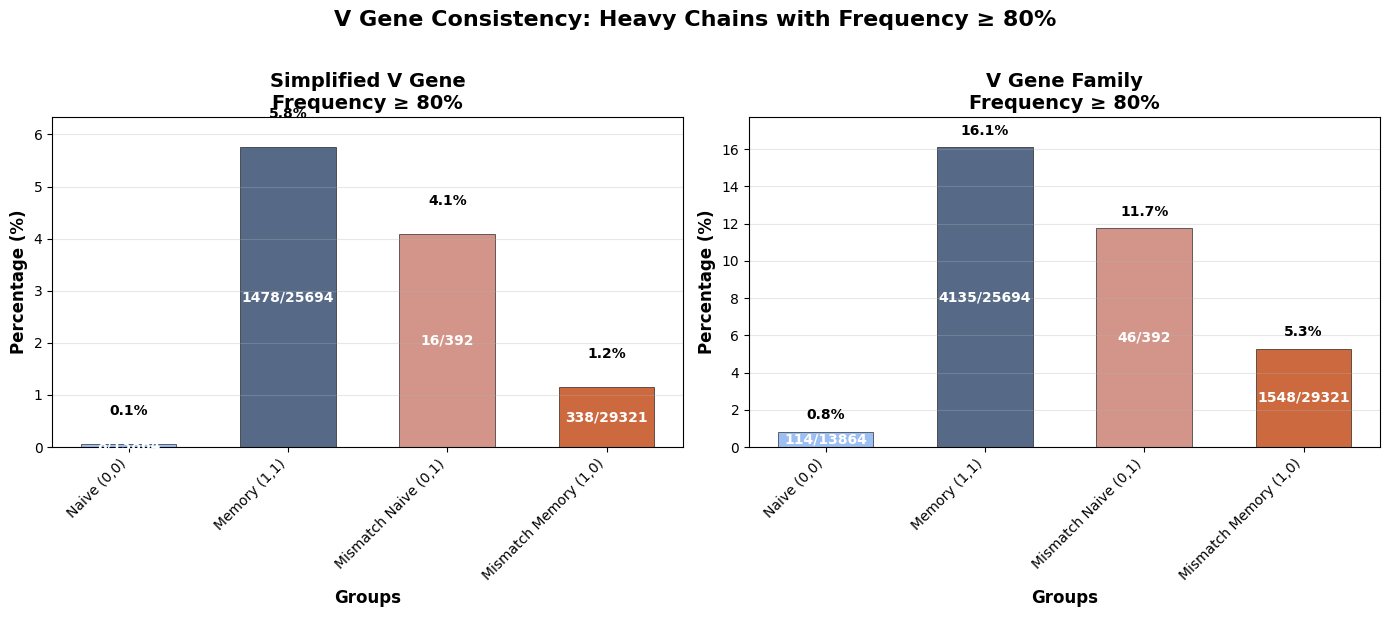

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_frequency_thresholds(results, threshold=75):
    """
    Visualize frequency >= threshold for all four groups across simplified and family V gene levels.
    
    Args:
        results (dict): Results from analyze_v_gene_consistency_by_groups
        threshold (int): Frequency threshold to analyze (default: 80)
    """
    
    # Define colors for each group
    colors = {
        'naive': '#83aff0',           # Light blue for naive (0,0)
        'memory': '#2c456b',          # Dark blue for memory (1,1)
        'mismatch_naive': '#c97b6d',  # Light red for mismatch naive (0,1)
        'mismatch_memory': '#c1440e'  # Dark red for mismatch memory (1,0)
    }
    
    # Define group labels
    group_labels = {
        'naive': 'Naive (0,0)',
        'memory': 'Memory (1,1)', 
        'mismatch_naive': 'Mismatch Naive (0,1)',
        'mismatch_memory': 'Mismatch Memory (1,0)'
    }
    
    # Levels to visualize
    levels = ['simplified', 'family']
    group_names = ['naive', 'memory', 'mismatch_naive', 'mismatch_memory']
    
    # Calculate data for visualization
    data = {}
    for level in levels:
        data[level] = {}
        for group_name in group_names:
            # Count heavy chains with frequency >= threshold
            count = 0
            total = len(results[group_name][level]['frequency_analysis'])
            
            for item in results[group_name][level]['frequency_analysis']:
                if item['dominant_frequency'] >= threshold:
                    count += 1
            
            percentage = (count / total * 100) if total > 0 else 0
            
            data[level][group_name] = {
                'count': count,
                'total': total,
                'percentage': percentage
            }
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar width and positions
    bar_width = 0.6
    x_positions = np.arange(len(group_names))
    
    # Plot for simplified V genes
    percentages_simplified = [data['simplified'][group]['percentage'] for group in group_names]
    bars1 = ax1.bar(x_positions, percentages_simplified, bar_width, 
                    color=[colors[group] for group in group_names],
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax1.set_xlabel('Groups', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Simplified V Gene\nFrequency ≥ {threshold}%', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([group_labels[group] for group in group_names], rotation=45, ha='right')
    ax1.set_ylim(0, max(percentages_simplified) * 1.1)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars1, percentages_simplified)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Add count/total below the percentage
        group = group_names[i]
        count = data['simplified'][group]['count']
        total = data['simplified'][group]['total']
        ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{count}/{total}', ha='center', va='center', 
                color='white', fontweight='bold', fontsize=10)
    
    # Plot for family V genes
    percentages_family = [data['family'][group]['percentage'] for group in group_names]
    bars2 = ax2.bar(x_positions, percentages_family, bar_width,
                    color=[colors[group] for group in group_names],
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax2.set_xlabel('Groups', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'V Gene Family\nFrequency ≥ {threshold}%', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([group_labels[group] for group in group_names], rotation=45, ha='right')
    ax2.set_ylim(0, max(percentages_family) * 1.1)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars2, percentages_family)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Add count/total below the percentage
        group = group_names[i]
        count = data['family'][group]['count']
        total = data['family'][group]['total']
        ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{count}/{total}', ha='center', va='center',
                color='white', fontweight='bold', fontsize=10)
    
    # Add overall title
    fig.suptitle(f'V Gene Consistency: Heavy Chains with Frequency ≥ {threshold}%', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    
    # Add legend
    # legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[group], alpha=0.8, edgecolor='black') 
    #                   for group in group_names]
    # legend_labels = [group_labels[group] for group in group_names]
    # fig.legend(legend_elements, legend_labels, loc='upper center', 
    #            bbox_to_anchor=(0.5, 0.95), ncol=4, fontsize=11)
    
    # Print summary statistics
    print(f"\nSUMMARY: Heavy chains with V gene frequency ≥ {threshold}%")
    print("=" * 60)
    
    for level in levels:
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 30)
        for group in group_names:
            group_data = data[level][group]
            print(f"{group_labels[group]:20s}: {group_data['count']:3d}/{group_data['total']:3d} = {group_data['percentage']:5.1f}%")
    
    plt.show()
    
    return data

def create_comparison_table(results, threshold=80):
    """Create a summary table of the frequency analysis."""
    
    levels = ['simplified', 'family']
    group_names = ['naive', 'memory', 'mismatch_naive', 'mismatch_memory']
    group_labels = {
        'naive': 'Naive (0,0)',
        'memory': 'Memory (1,1)', 
        'mismatch_naive': 'Mismatch Naive (0,1)',
        'mismatch_memory': 'Mismatch Memory (1,0)'
    }
    
    # Create summary data
    summary_data = []
    
    for level in levels:
        for group_name in group_names:
            # Count heavy chains with frequency >= threshold
            count = 0
            total = len(results[group_name][level]['frequency_analysis'])
            
            for item in results[group_name][level]['frequency_analysis']:
                if item['dominant_frequency'] >= threshold:
                    count += 1
            
            percentage = (count / total * 100) if total > 0 else 0
            
            summary_data.append({
                'V_Gene_Level': level.title(),
                'Group': group_labels[group_name],
                'Group_Code': group_name,
                'Count': count,
                'Total': total,
                'Percentage': percentage
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save to CSV
    #summary_df.to_csv(f'v_gene_frequency_threshold_{threshold}_summary.csv', index=False)
    print(f"\nSummary table saved to: v_gene_frequency_threshold_{threshold}_summary.csv")
    
    return summary_df


# Create the visualization
data = visualize_frequency_thresholds(results, threshold=80)

# Create summary table
# summary_df = create_comparison_table(results, threshold=80)

In [17]:
# Create the visualization
data = visualize_frequency_thresholds(results, threshold=80)

TypeError: 'NoneType' object is not subscriptable

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_frequency_thresholds(results, threshold=80):
    """
    Visualize frequency >= threshold for all four groups across simplified and family V gene levels.
    
    Args:
        results (dict): Results from analyze_v_gene_consistency_by_groups
        threshold (int): Frequency threshold to analyze (default: 80)
    """
    
    # Define colors for each group
    colors = {
        'naive': '#83aff0',           # Light blue for naive (0,0)
        'memory': '#2c456b',          # Dark blue for memory (1,1)
        'mismatch_naive': '#c97b6d',  # Light red for mismatch naive (0,1)
        'mismatch_memory': '#c1440e'  # Dark red for mismatch memory (1,0)
    }
    
    # Define group labels
    group_labels = {
        'naive': 'Match naive',
        'memory': 'Match memory', 
        'mismatch_naive': 'Mismatch naive',
        'mismatch_memory': 'Mismatch memory'
    }
    
    # Levels to visualize
    levels = ['simplified', 'family']
    group_names = ['naive', 'memory', 'mismatch_naive', 'mismatch_memory']
    
    # Calculate data for visualization
    data = {}
    for level in levels:
        data[level] = {}
        for group_name in group_names:
            # Count heavy chains with frequency >= threshold
            count = 0
            total = len(results[group_name][level]['frequency_analysis'])
            
            for item in results[group_name][level]['frequency_analysis']:
                if item['dominant_frequency'] >= threshold:
                    count += 1
            
            percentage = (count / total * 100) if total > 0 else 0
            
            data[level][group_name] = {
                'count': count,
                'total': total,
                'percentage': percentage
            }
    
    # Create individual plots
    bar_width = 0.6
    x_positions = np.arange(len(group_names))
    
    # Plot for simplified V genes
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_alpha(0.0)  # Make figure transparent
    ax1.patch.set_alpha(0.0)   # Make axis transparent
    
    percentages_simplified = [data['simplified'][group]['percentage'] for group in group_names]
    bars1 = ax1.bar(x_positions, percentages_simplified, bar_width, 
                    color=[colors[group] for group in group_names],
                    alpha=1.0, edgecolor='black', linewidth=0.5)
    
    ax1.set_ylabel('V gene sharing', fontsize=20)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([group_labels[group] for group in group_names], fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_ylim(0, max(percentages_simplified) * 1.1)

    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars1, percentages_simplified)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Add count/total below the percentage
        # group = group_names[i]
        # count = data['family'][group]['count']
        # total = data['family'][group]['total']
        # ax2.text(bar.get_x() + bar.get_width()/2., height/2,
        #         f'{count}/{total}', ha='center', va='center',
        #         color='white', fontweight='bold', fontsize=10)

    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('v_gene_simplified_frequency.png', bbox_inches='tight', transparent=True, dpi=600)
    plt.show()
    
    # Plot for family V genes
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_alpha(0.0)  # Make figure transparent
    ax2.patch.set_alpha(0.0)   # Make axis transparent
    
    percentages_family = [data['family'][group]['percentage'] for group in group_names]
    bars2 = ax2.bar(x_positions, percentages_family, bar_width,
                    color=[colors[group] for group in group_names],
                    alpha=1.0, edgecolor='black', linewidth=0.5)
    
    ax2.set_ylabel('V gene family sharing', fontsize=20)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([group_labels[group] for group in group_names], fontsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax2.set_ylim(0, max(percentages_family) * 1.1)

    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars2, percentages_family)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Add count/total below the percentage
        # group = group_names[i]
        # count = data['family'][group]['count']
        # total = data['family'][group]['total']
        # ax2.text(bar.get_x() + bar.get_width()/2., height/2,
        #         f'{count}/{total}', ha='center', va='center',
        #         color='white', fontweight='bold', fontsize=10)
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('v_gene_family_frequency_min_80.png', bbox_inches='tight', transparent=True, dpi=600)
    plt.show()

    
    # Print summary statistics
    print(f"\nSUMMARY: Heavy chains with V gene frequency ≥ {threshold}%")
    print("=" * 60)
    
    for level in levels:
        print(f"\n{level.upper()} V GENE LEVEL:")
        print("-" * 30)
        for group in group_names:
            group_data = data[level][group]
            print(f"{group_labels[group]:20s}: {group_data['count']:3d}/{group_data['total']:3d} = {group_data['percentage']:5.1f}%")
    
    return data



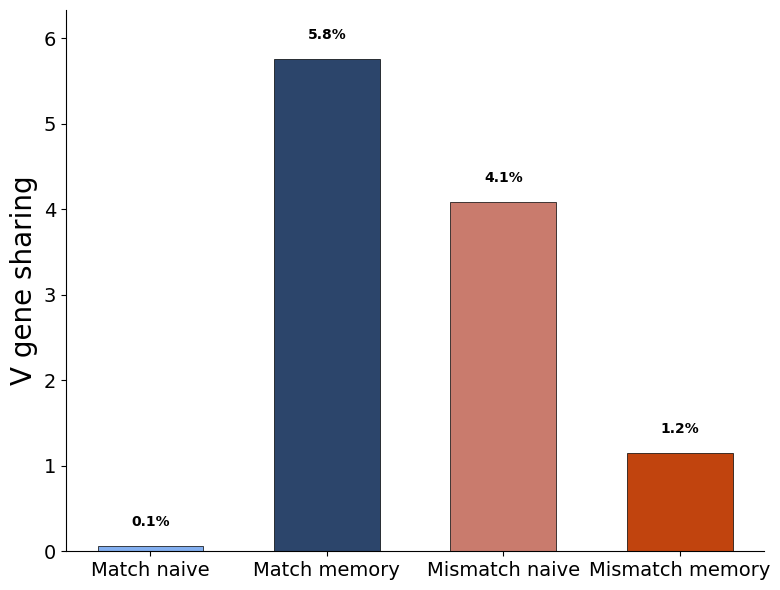

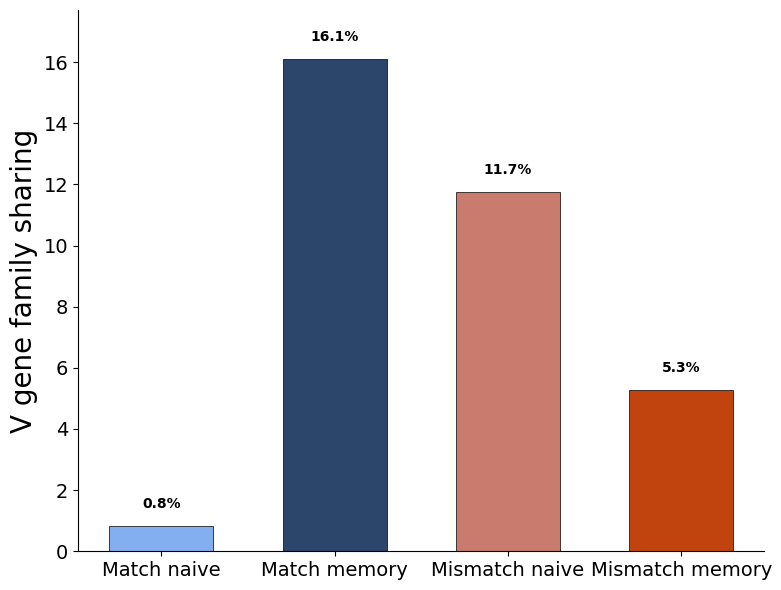


SUMMARY: Heavy chains with V gene frequency ≥ 80%

SIMPLIFIED V GENE LEVEL:
------------------------------
Match naive         :   8/13864 =   0.1%
Match memory        : 1478/25694 =   5.8%
Mismatch naive      :  16/392 =   4.1%
Mismatch memory     : 338/29321 =   1.2%

FAMILY V GENE LEVEL:
------------------------------
Match naive         : 114/13864 =   0.8%
Match memory        : 4135/25694 =  16.1%
Mismatch naive      :  46/392 =  11.7%
Mismatch memory     : 1548/29321 =   5.3%


In [31]:
data = visualize_frequency_thresholds(results, threshold=80)